Install PySpark

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 39 kB/s 
     |████████████████████████████████| 199 kB 43.7 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=9562281f3b806d29f50e089d2d63bced855e8afce2586f14ac98999246a747fc
  Stored in directory: /root/.cache/pip/wheels/42/59/f5/79a5bf931714dcd201b26025347785f087370a10a3329a899c
Successfully built pyspark


Initialize Spark session

In [ ]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]") \
                    .config("spark.driver.memory","10g") \
                    .appName('demo_pca') \
                    .getOrCreate()

22/11/30 09:34:51 WARN Utils: Your hostname, sigmac-2.local resolves to a loopback address: 127.0.0.1; using 192.168.250.88 instead (on interface en0)
22/11/30 09:34:51 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/30 09:34:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/11/30 09:34:51 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Upload data files
https://drive.google.com/drive/folders/1-7An39gzRc0I_7hEex4j7L2djS7_EehK?usp=sharing

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Or mount google drive, drag drop shared folder to My Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Check mount

In [ ]:
!ls /content/drive/MyDrive/spark-notebooks/

cov19_pca.tsv	      README.md				vert.csv
cov19.tre	      spark_graphframes_pagerank.ipynb	vertices.csv
cov19_variants.fasta  spark_ml_pca.ipynb
edges.csv	      spark-warehouse


In [ ]:
cat /proc/meminfo

MemTotal:       13297228 kB
MemFree:         5246508 kB
MemAvailable:   10705356 kB
Buffers:          328300 kB
Cached:          4869708 kB
SwapCached:            0 kB
Active:          1020988 kB
Inactive:        6717840 kB
Active(anon):       1308 kB
Inactive(anon):  2147972 kB
Active(file):    1019680 kB
Inactive(file):  4569868 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:              1300 kB
Writeback:             0 kB
AnonPages:       2541008 kB
Mapped:           329016 kB
Shmem:              1172 kB
KReclaimable:     195224 kB
Slab:             229212 kB
SReclaimable:     195224 kB
SUnreclaim:        33988 kB
KernelStack:        6448 kB
PageTables:        23644 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6648612 kB
Committed_AS:    5270804 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       11192 kB
VmallocChunk:          0 kB
Percpu:          

Variants from ~500 SARS-Cov-2 strains, cov19_variants.fasta
https://webfasta.appspot.com (data from. https://www.ncbi.nlm.nih.gov/sars-cov-2/). Sequecnce are around 30k bases long. Multiple sequence alignment using MAFFT. Non variant sites removed to a total of ~2000nt

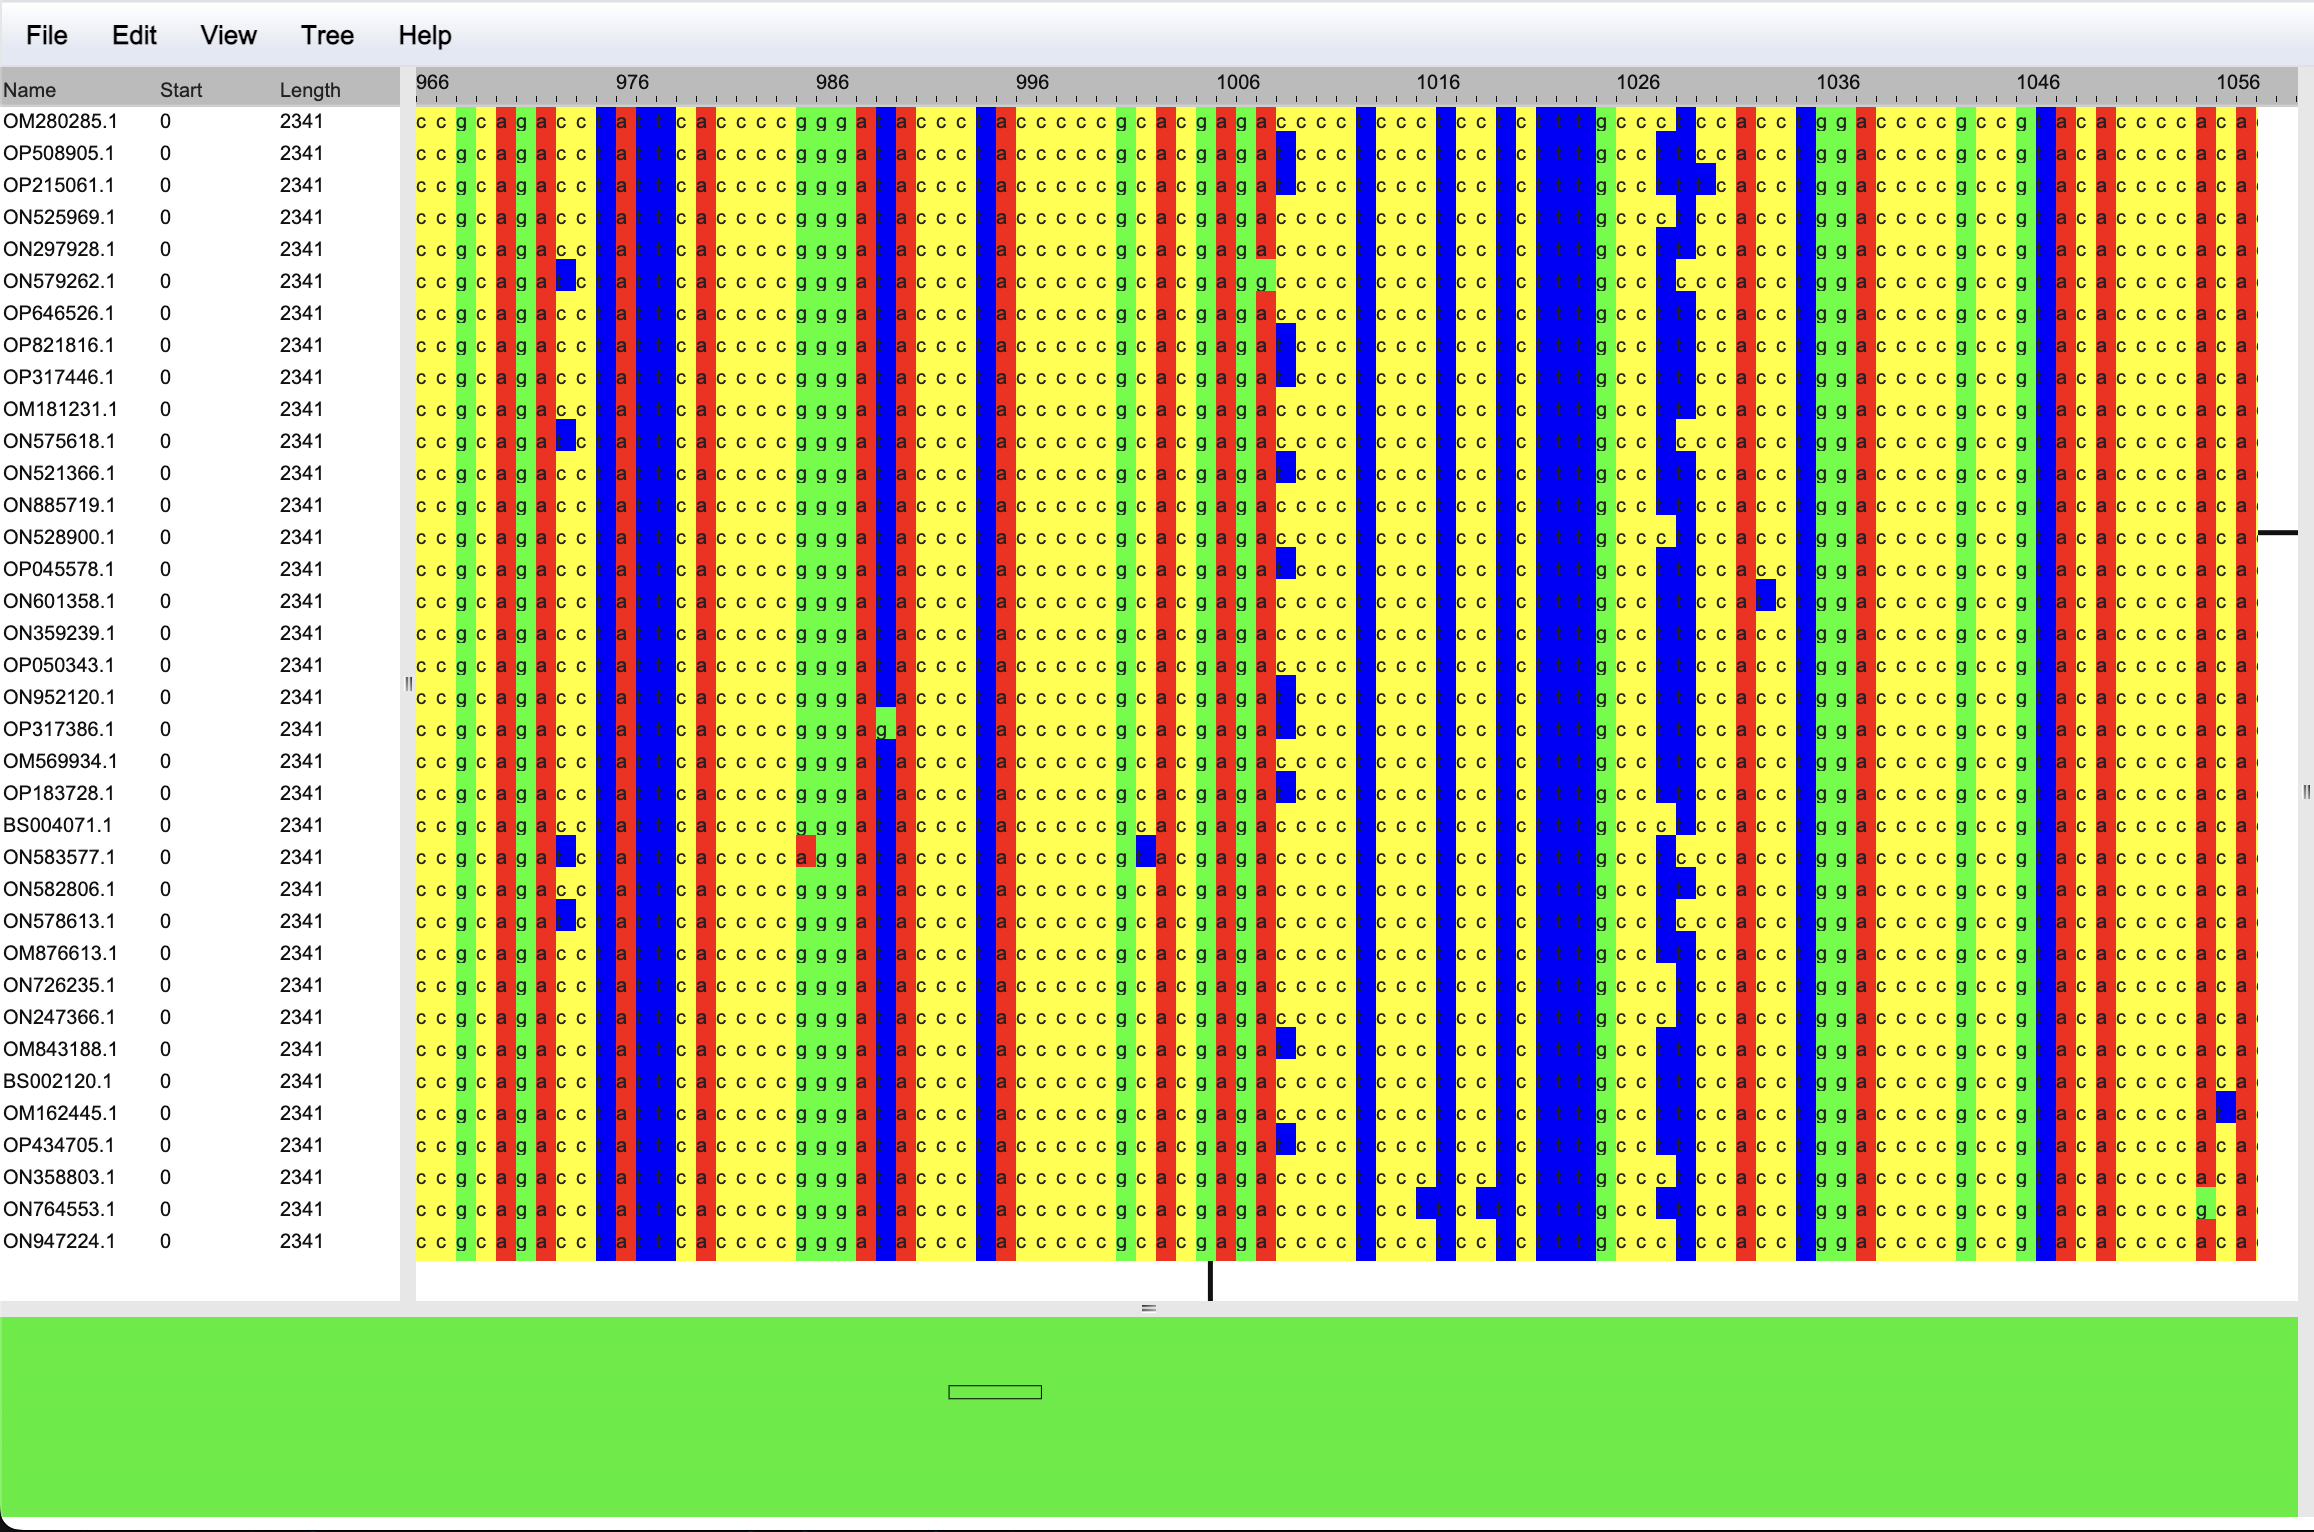

Load aligned sequence fasta file in Spark. One hot encode before using with Spark ML

In [ ]:
root = "/Users/sigmar/Google Drive/My Drive/"
#root = "/content/drive/MyDrive/"

import numpy as np
import pyarrow as pa
import time
from pyspark.sql.functions import expr
from pyspark.sql.functions import split
from pyspark.sql.functions import ascii
from pyspark.sql.functions import col
from pyspark.ml.functions import array_to_vector
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.feature import PCA
import pyspark.sql.types as T

def one_hot(iterator):
    onehot = {"a":[0,0], "g":[0,1], "c":[1,0], "t":[1,1]}
    for batch in iterator:
        batch["sequence"] = [[o for k in sublist for o in onehot[k]] for sublist in batch["sequence"]]
        yield batch

df = spark.read.format("csv").option("lineSep",">").option("delimiter"," ").load(root+"spark-notebooks/cov19_variants.fasta")
df = df.withColumnRenamed("_c0","name")
df = df.withColumnRenamed("_c1","sequence")
df = df.withColumn("sequence", expr("regexp_replace(sequence,'\n','')"))
ddl_schema_string = "name string,sequence array<int>"
nschema = T._parse_datatype_string(ddl_schema_string)
df = df.mapInPandas(one_hot, nschema)
df = df.withColumn("sequence", array_to_vector(col("sequence")))
df.toPandas()

,name,sequence
0,ON223024.1,"[1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ..."
1,OP398128.1,"[1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ..."
2,ON288022.1,"[1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ..."
3,OP521150.1,"[1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ..."
4,OP003120.1,"[1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ..."
...,...,...
571,OP002972.1,"[1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ..."
572,ON885528.1,"[1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ..."
573,OP066428.1,"[1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ..."
574,OM797449.1,"[1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ..."


Calculate PCA in 3 dimensions (7 minutes on a free Colab node)

In [ ]:
pca = PCA(k=3, inputCol="sequence")
model = pca.fit(df)
model.setOutputCol("output")
pcaresults = model.transform(df).select("name","output")
pandaspca = pcaresults.toPandas()
pandaspca

22/11/30 09:37:00 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/11/30 09:37:00 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/11/30 09:37:00 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


22/11/30 09:37:03 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/11/30 09:37:03 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


,name,output
0,ON223024.1,"[-2.8617761722055657, 3.0711542945052983, 1.39..."
1,OP398128.1,"[4.060067824816213, -1.1375530254341673, 1.803..."
2,ON288022.1,"[1.9197265273261186, 0.06725994149747459, -2.2..."
3,OP521150.1,"[-2.810005489781995, 3.1474909582335484, 1.383..."
4,OP003120.1,"[-2.891151958706738, 3.403388467956885, 1.5017..."
...,...,...
571,OP002972.1,"[-2.8985804229876813, 3.3888178158687774, 1.50..."
572,ON885528.1,"[-3.833967987658301, -2.8014662141248547, 0.63..."
573,OP066428.1,"[-3.8397313415959142, -2.8088006453538594, 0.6..."
574,OM797449.1,"[1.9217264967975476, 0.06999648093044845, -2.2..."


Save and download result file

In [ ]:
pandas_pca = pcaresults.toPandas()

import pandas as pd
country_df = pd.read_csv(root+'spark-notebooks/cov19_country_mapping.tsv', sep='\t', header=0, names=['name', 'country'], index_col=0)
#country_df.set_index('name')
country_df

,country
name,
OP604184.2,Australia
OP604177.2,Australia
ON112352.1,Austria
ON112351.1,Austria
OM283601.1,Austria
...,...
ON764548.1,Viet Nam
ON755495.1,Viet Nam
OP326057.1,Viet Nam


In [ ]:
country_dict = country_df['country'].to_dict()
pandas_pca["name"] = pandas_pca["name"].replace(country_dict)

pandas_pca.to_csv("pcares.tsv",sep="\t",index=0)
pandas_pca

,name,output
0,USA,"[-2.8617761722055657, 3.0711542945052983, 1.39..."
1,USA,"[4.060067824816213, -1.1375530254341673, 1.803..."
2,France,"[1.9197265273261186, 0.06725994149747459, -2.2..."
3,USA,"[-2.810005489781995, 3.1474909582335484, 1.383..."
4,USA,"[-2.891151958706738, 3.403388467956885, 1.5017..."
...,...,...
571,USA,"[-2.8985804229876813, 3.3888178158687774, 1.50..."
572,USA,"[-3.833967987658301, -2.8014662141248547, 0.63..."
573,USA,"[-3.8397313415959142, -2.8088006453538594, 0.6..."
574,USA,"[1.9217264967975476, 0.06999648093044845, -2.2..."


In [ ]:
from google.colab import files
files.download('pcares.tsv')

/Users/sigmar/Google Drive/My Drive/spark-notebooks/cov19_country_mapping.tsv


View in 3D https://graph3d.web.app/

In [ ]:
from IPython.display import IFrame
IFrame("https://graph3d.web.app/", 1440,900)